# Sensitivity Analysis on the beam model
This notebook, is an example of the application of the KLFS module on a beam model problem.
It is devided into two parts, the first is the computing of SA on the origina beam model, the seond part is the computing of the SA on a kriging metamodel replacing the beam model.0

In [1]:
# from here on, all our modules and helper functions are imported
from my_functions import *
import klfs
import beam_example as MODEL
import pythontools as pyto

len vertices is: 101


In [27]:
# to avoid a bug in openturns
import openturns as ot 
ot.Log.Show(ot.Log.NONE)

### Initiate some parameters

In [3]:
seed_number = 111 # seed number
size_sa = 1e2 # size od the sensitivity anlysis samples
second_order_activate = True # activate second order or no in klfs.KarhunenLoeveSobolIndicesExperiment() class
size_sa_krig = int(1e5)
seed_krig_sa = 1253
doe_size_kirg = 150
size_validation = 1000

### Define the random parameters of the model (stochastic process and classic distribution)

In [4]:
# Definition of the model parameters 
dim          = 1
n_elements   = 99
min_vertices = 0    #mm
max_vertices = 1000 #mm

coef_var = .05
mean_young,  mean_diam  = 210000, 10  #MPa, mm
scale_young, scale_diam = 300,    250 #mm, mm
nu_young,    nu_diam    = 5,      5   #scalar

mean_pos_force,  mean_norm_force   = 500, 100 #N, mm
sigma_pos_force, sigma_norm_force  = 25,  5   #N, mm

fem_vertices = get_fem_vertices(min_vertices, max_vertices, n_elements)

# Karhunen-Loeve decomposition of two stochastic processes: Young's Modulus and Diameter  
kl_results_E = get_process_kl_decomposition(mean = mean_young, coef_var = coef_var, scale = scale_young, 
                    nu = nu_young, mesh = fem_vertices, dimension = dim, name = 'E_', threshold= 1e-3)

kl_results_D = get_process_kl_decomposition(mean = mean_diam, coef_var = coef_var, scale = scale_diam, 
                    nu = nu_diam, mesh = fem_vertices, dimension = dim, name = 'D_', threshold= 1e-3)
# The two scalar random variables : 
pos_force = ot.Normal(mean_pos_force, sigma_pos_force)
pos_force.setName('F_Pos_')

norm_force  = ot.Normal(mean_norm_force, sigma_norm_force)
norm_force.setName('F_Norm_')

### Define the klfs.AggregatedKarhunenLoeveResults()  class

In [5]:
# define the list of kl results (stochastic process) and distribution
kl_results_list = [kl_results_E, kl_results_D, pos_force, norm_force]
# define the class AggregatedKarhunenLoeveResults()
AggregatedKLRes = klfs.AggregatedKarhunenLoeveResults(kl_results_list)
# set the mean of the stochastic results
# for other indices the means are initialized from the distributions
AggregatedKLRes.setMean(0, mean_young) 
AggregatedKLRes.setMean(1, mean_diam) 

AggregatedKLRes.setLiftWithMean(True)

### Define the beam model and define the klfs.KarhunenLoeveGeneralizedFunctionWrapper()

In [6]:
# definition of the model :
_MODEL = MODEL.PureBeam()
# initialization of the function wrapper : 
FUNC = klfs.KarhunenLoeveGeneralizedFunctionWrapper(
            AggregatedKarhunenLoeveResults = AggregatedKLRes,
            func        = None, 
            func_sample = _MODEL.batchEval,
            n_outputs   = 2)
# FUNC_wSave = function_with_save_wrapper(FUNC) # save function

### Generate the experiments samples of the sensitivity analysis 

In [7]:
ot.RandomGenerator.SetSeed(seed_number)
size = int(size_sa)
experiment = klfs.KarhunenLoeveSobolIndicesExperiment(AggregatedKLRes, size, second_order_activate)
sobolExp = experiment.generate()

Generating samples for the second order indices
Samples A and B of size 100 and dimension 15
Experiment for second order generated
Experiment of size 1000 and dimension 15


### Compute the SA experiments samples by the model

In [8]:
response = FUNC(sobolExp)

field E shape (1000, 100)
var_Fnor shape (1000,)
field_E 209227.94579789907 field_D 9.998785002927354 var_Fpos 500.00579414419593 var_Fnor 99.87198933658763


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   25.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.9s finished
/home/braydi/miniconda3/envs/env_test123/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


shape deflection:  (1000, 101)  should be [N,10X] something
deflection std deviation 3.8946727479905205
Using the batch evaluation function. Assumes that the outputs are in the
same order than for the single evaluation function. This one should only
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (1000, 100) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (1, 1000) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns process samples of dimension 1


### Compute the Sobol indices for SA using the klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm() class

In [9]:
# Ici on calcule les indices de Sobol' pour le champs de contraintes de von mises

sensitivityAnalysis_vonMises = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm(computeSecondOrder=second_order_activate)
sensitivityAnalysis_vonMises.setDesign(sobolExp, response[0], size)
sensitivityAnalysis_vonMises.setEstimator(ot.SaltelliSensitivityAlgorithm())
print('number of SI per output:',sensitivityAnalysis_vonMises.__nSobolIndices__)

size initialized 1000
Means is
 [1.48839,13.0524,25.522,37.5734,49.2007,60.4156,71.2315,81.6595,91.7078,101.382,110.685,119.619,128.187,136.389,144.229,151.711,158.842,165.627,172.074,178.194,183.996,189.489,194.684,199.593,204.226,208.593,212.705,216.572,220.168,223.543,226.672,229.601,232.309,234.754,236.967,238.94,240.71,242.219,243.462,244.483,245.307,246.022,246.491,246.819,247.005,247.147,247.234,247.264,247.262,247.222,247.175,247.097,246.997,246.874,246.698,246.452,246.086,245.614,245.069,244.353,243.532,242.525,241.405,240.126,238.634,236.987,235.103,232.972,230.601,227.977,225.169,222.136,218.87,215.386,211.674,207.723,203.521,199.057,194.318,189.29,183.96,178.315,172.34,166.021,159.346,152.303,144.882,137.076,128.878,120.286,111.3,101.922,92.1543,82.0009,71.4637,60.543,49.2368,37.5415,25.4548,12.9925]#100
design_elem size, dim 1000 100
There are 4 indices to get for 1 outputs with dimensions 100 each.
Description all same? [E__0,E__1,E__2,E__3,E__4,E__5,D__0,D__1,D__2,D__3,D

### Compute and print sobol indices for VonMises filed output

In [10]:
sobol_FO_VonMises = sensitivityAnalysis_vonMises.getFirstOrderIndices()
sobol_TO_VonMises = sensitivityAnalysis_vonMises.getTotalOrderIndices()

Solving...
 size of samples:  1000
 number of indices to get 4


In [11]:
print(sobol_FO_VonMises[0][2].getName())
print(sobol_FO_VonMises[0][0].__class__)
print(sobol_FO_VonMises[0][0].getSize())
# Print the sobol indices for the first five VonMises filed elemnts
sobol_YoungsModulus = sobol_FO_VonMises[0][0].getValues()
display('SI first order YoungsModulus:',sobol_YoungsModulus[:5])
sobol_Diameter      = sobol_FO_VonMises[0][1].getValues()
display('SI first order  Diameter:',sobol_Diameter[:5])
sobol_ForcePos      = sobol_FO_VonMises[0][2].getValues()
display('SI first order  ForcePos:',sobol_ForcePos[:5])
sobol_ForceNorm     = sobol_FO_VonMises[0][3].getValues()
display('SI first order  ForceNorm:',sobol_ForceNorm[:5])

Sobol_Y_0_F_Pos_
<class 'openturns.func.Field'>
100


'SI first order YoungsModulus:'

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[v0] data=[[-0.0250133],[0.00708364],[0.0324084],[0.0566513],[0.0780308]]

'SI first order  Diameter:'

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[v0] data=[[0.680348],[0.845568],[0.815852],[0.781075],[0.74649]]

'SI first order  ForcePos:'

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[v0] data=[[0.128733],[0.0864239],[0.112054],[0.137003],[0.159113]]

'SI first order  ForceNorm:'

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[v0] data=[[0.223959],[0.16989],[0.187772],[0.203867],[0.216603]]

### Compute and print sobol indices for maximum deflection output

In [12]:
# Ici on calcule les indices de Sobol' pour la déflexion maximale

sensitivityAnalysis_maxDefl = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm(computeSecondOrder=second_order_activate)
# ICI il faut prendre response[1][0]
sensitivityAnalysis_maxDefl.setDesign(sobolExp, response[1][0], size)
sensitivityAnalysis_maxDefl.setEstimator(ot.SaltelliSensitivityAlgorithm())
sobol_FO_maxDefl = sensitivityAnalysis_maxDefl.getFirstOrderIndices()
sobol_TO_maxDefl = sensitivityAnalysis_maxDefl.getTotalOrderIndices()


size initialized 1000
Means is
 [20.7786]
design_elem size, dim 1000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [E__0,E__1,E__2,E__3,E__4,E__5,D__0,D__1,D__2,D__3,D__4,D__5,D__6,F_Pos__0,F_Norm__0]#15
SobolIndicesName ['E_', 'D_', 'F_Pos_', 'F_Norm_']
Input Description is, ['E_', 'D_', 'F_Pos_', 'F_Norm_']
Solving...
 size of samples:  1000
 number of indices to get 4


In [13]:
print(sobol_FO_maxDefl[0][2].getName())
print(sobol_FO_maxDefl[0][0].__class__)
print(sobol_FO_maxDefl[0][0].getSize())

sobol_YoungsModulus = sobol_FO_maxDefl[0][0]
sobol_Diameter      = sobol_FO_maxDefl[0][1]
sobol_ForcePos      = sobol_FO_maxDefl[0][2]
sobol_ForceNorm     = sobol_FO_maxDefl[0][3]

print('sobol_YoungsModulus = ',sobol_YoungsModulus,
      '\n sobol_Diameter = ',sobol_Diameter,
      '\n sobol_ForcePos = ',sobol_ForcePos,
      '\n sobol_ForceNorm = ',sobol_ForceNorm)


Sobol_Unnamed_F_Pos_
<class 'openturns.typ.Point'>
1
sobol_YoungsModulus =  [0.218041] 
 sobol_Diameter =  [1.26453] 
 sobol_ForcePos =  [0.188134] 
 sobol_ForceNorm =  [0.327237]


## Compte SA with metamodel of the maximum deflection

### Build and validate the kiging metamodel

In [14]:
RandomNormalVector = getRandomNormalVector(AggregatedKLRes)

In [15]:
# DOE samples
doe_kriging_LHS = optimizedLHS(RandomNormalVector, doe_size_kirg, 758295729577843)  #SEED: 758295729577843
response_doe = FUNC(doe_kriging_LHS)
doe_kriging_LHS_MD = response_doe[1][0]
# Validation samples
doe_kriging_validation = optimizedLHS(RandomNormalVector, size_validation, 315681856881426) #SEED: 315681856881426
response_validation = FUNC(doe_kriging_validation)
doe_kriging_validation_MD = response_validation[1][0]

field E shape (150, 100)
var_Fnor shape (150,)
field_E 209995.64209072068 field_D 9.998742900677582 var_Fpos 500.10189778823485 var_Fnor 100.00728769954287


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.5s finished
/home/braydi/miniconda3/envs/env_test123/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


shape deflection:  (150, 101)  should be [N,10X] something
deflection std deviation 3.8327581103631885
Using the batch evaluation function. Assumes that the outputs are in the
same order than for the single evaluation function. This one should only
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (150, 100) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (1, 150) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns process samples of dimension 1
field E shape (1000, 100)
var_Fnor shape (1000,)
field_E 210002.4235761342 field_D 10.000061089934388 var_Fpos 500.0067716224304 var_Fnor 99.9910585678642


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   27.0s finished


shape deflection:  (1000, 101)  should be [N,10X] something
deflection std deviation 3.823047330471203
Using the batch evaluation function. Assumes that the outputs are in the
same order than for the single evaluation function. This one should only
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (1000, 100) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (1, 1000) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns process samples of dimension 1


In [16]:
# Definition d'un krigeage avec une seule sortie et avec des valeurs des paramètres prises par défaut
krig_MD = pyto.KrigingModel(input_sample=doe_kriging_LHS, output_sample=doe_kriging_LHS_MD)

In [17]:
# lower_bound=None, upper_bound=None, size=100, optim_type='multi_start'
kriging_default = krig_MD.run_optim()

In [18]:
## calcul des valeurs de q2 pour les métamodèles construits par la méthode "fit"
## remarque: le calcul de q2 pour les métamodèles construit avec "fit_by_integration" n'ai pas disponble
display(krig_MD.compute_q2())

,v0
Q2,0.992094


In [19]:
 ## calcul des valeurs de r2 pour les métamodèles en se basant sur les échantillons test
display(krig_MD.compute_r2(doe_kriging_validation, doe_kriging_validation_MD))

,v0
R2,[0.9913787678733105]


/home/braydi/miniconda3/envs/env_test123/lib/python3.9/site-packages/pythontools-0.0.1-py3.9.egg/pythontools/_kriging_module.py:406: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


[<Figure size 576x576 with 1 Axes>]

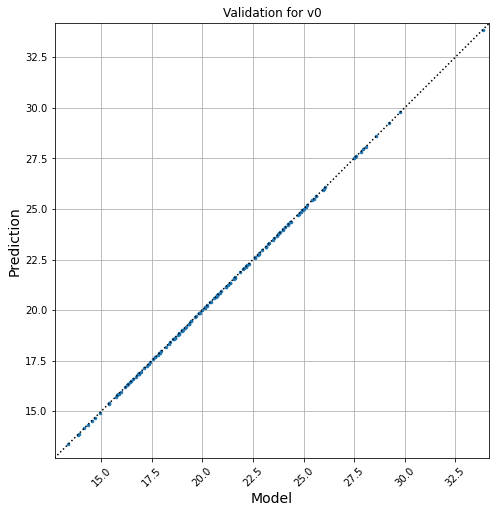

In [20]:
krig_MD.draw_validation()

In [21]:
## get the metamodel function
meta_krig_MD = krig_MD.get_metamodel()

### SA with Metamodel

In [22]:
def getSobolExperiment(aggregated_karhunen_loeve_results, size, seed, secondOrder=second_order_activate):
    ot.RandomGenerator.SetSeed(seed)
    experiment = klfs.KarhunenLoeveSobolIndicesExperiment(aggregated_karhunen_loeve_results, size, secondOrder)
    sobolExp = experiment.generate()
    return sobolExp, experiment

In [23]:
sobol_experiment_krig, experiment_krig = getSobolExperiment(AggregatedKLRes, size_sa_krig, seed_krig_sa) 

Generating samples for the second order indices
Samples A and B of size 100000 and dimension 15
Experiment for second order generated
Experiment of size 1000000 and dimension 15


In [24]:
results_krig_MD = meta_krig_MD(sobol_experiment_krig)

In [25]:
# Ici on calcule les indices de Sobol' pour la déflexion maximale
SA_maxDefl_krig = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm(
    computeSecondOrder=second_order_activate)
SA_maxDefl_krig.setDesign(sobol_experiment_krig, results_krig_MD, size_sa_krig)
SA_maxDefl_krig.setEstimator(ot.SaltelliSensitivityAlgorithm())
sobol_FO_maxDefl_krig = SA_maxDefl_krig.getFirstOrderIndices()
sobol_TO_maxDefl_krig = SA_maxDefl_krig.getTotalOrderIndices()

size initialized 1000000
Means is
 [20.6772]
design_elem size, dim 1000000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [E__0,E__1,E__2,E__3,E__4,E__5,D__0,D__1,D__2,D__3,D__4,D__5,D__6,F_Pos__0,F_Norm__0]#15
SobolIndicesName ['E_', 'D_', 'F_Pos_', 'F_Norm_']
Input Description is, ['E_', 'D_', 'F_Pos_', 'F_Norm_']
Solving...
 size of samples:  1000000
 number of indices to get 4


In [26]:
# Print the results of the SI first order for each input
print(sobol_FO_maxDefl_krig[0][2].getName())
print(sobol_FO_maxDefl_krig[0][0].__class__)
print(sobol_FO_maxDefl_krig[0][0].getSize())

sobol_YoungsModulus = sobol_FO_maxDefl_krig[0][0]
sobol_Diameter      = sobol_FO_maxDefl_krig[0][1]
sobol_ForcePos      = sobol_FO_maxDefl_krig[0][2]
sobol_ForceNorm     = sobol_FO_maxDefl_krig[0][3]

print('sobol_YoungsModulus = ',sobol_YoungsModulus,
      '\n sobol_Diameter = ',sobol_Diameter,
      '\n sobol_ForcePos = ',sobol_ForcePos,
      '\n sobol_ForceNorm = ',sobol_ForceNorm )

Sobol_Unnamed_F_Pos_
<class 'openturns.typ.Point'>
1
sobol_YoungsModulus =  [0.0515591] 
 sobol_Diameter =  [0.87262] 
 sobol_ForcePos =  [-0.00354409] 
 sobol_ForceNorm =  [0.0650373]
len vertices is: 101
len vertices is: 101
len vertices is: 101
len vertices is: 101
